In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from useful_functions import *
import seaborn as sns
from config_path import MS_DATA_PATH
print(MS_DATA_PATH)

Base path: ..
../data/ms


In [2]:


df = pd.read_csv(f'{MS_DATA_PATH}/220316_ghost_nrt_filtered.tsv', sep='\t')
design_matrix = pd.read_csv(f'{MS_DATA_PATH}/design_matrix_group_de_early_time_points_subtypes.tsv', sep='\t')

GroupOneCols = design_matrix[design_matrix['Group'] == 1]['Sample'].values
GroupTwoCols = design_matrix[design_matrix['Group'] == 2]['Sample'].values



### Peptide distribution in samples

# unique proteins: 1039 


<Figure size 432x288 with 0 Axes>

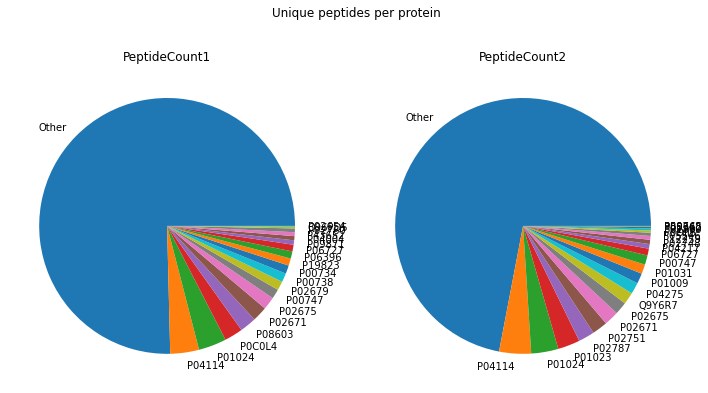

In [3]:
nr_unique_proteins = len(df['Protein'].unique())
print(f'# unique proteins: {nr_unique_proteins} ')

df['PeptideCount1'] = df[GroupOneCols].count(axis=1)
df['PeptideCount2'] = df[GroupTwoCols].count(axis=1)
df['IntensitySum1'] = df[GroupOneCols].sum(axis=1)
df['IntensitySum2'] = df[GroupTwoCols].sum(axis=1)
df['IntensityMean1'] = df[GroupOneCols].mean(axis=1)
df['IntensityMean2'] = df[GroupTwoCols].mean(axis=1)
df['FC'] = df['IntensityMean1'] / df['IntensityMean2']
df['IntensitySum'] = df['IntensitySum1'] + df['IntensitySum2']

def savefig(figureFileName):
    plt.tight_layout()
    plt.savefig(f'../plots/{figureFileName}.jpg', dpi=300, bbox_inches='tight')

def plot_peptides_per_protein_piechart(df):
    plt.clf()
    nr_proteins = 25
    def make_other_label(row, top_x_proteins):
        if row['Protein'] in top_x_proteins:
               return row['Protein']
        else:
            return 'Other'
    fig, axs = plt.subplots(1,2, figsize=(10,6))
    for ax, PeptideCount in zip(axs.ravel(), ['PeptideCount1','PeptideCount2']):
        df.sort_values(PeptideCount, ascending=False, inplace=True)
        top_x_proteins = df['Protein'][0:nr_proteins].values
        df['labels'] = df.apply(lambda x: make_other_label(x, top_x_proteins), axis=1)
        df_grouped = df.groupby('labels', as_index=False).sum()
        df_grouped.sort_values(PeptideCount, ascending=False, inplace=True)
        ax.pie(x=df_grouped[PeptideCount].values[0:nr_proteins], labels=df_grouped['labels'].values[0:nr_proteins])
        ax.set_title(PeptideCount)
    plt.suptitle('Unique peptides per protein')
    savefig('Protein_pie')
    
plot_peptides_per_protein_piechart(df)


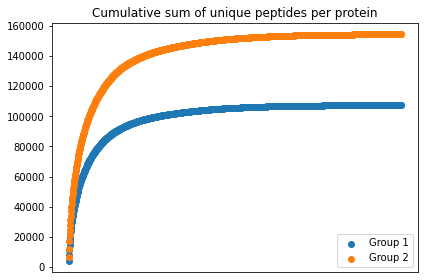

In [24]:
def plot_peptide_distribution(df):
    plt.clf()
    fig = plt.Figure()
    df = df.groupby('Protein', as_index=False).sum()
    for PeptideCount in ['PeptideCount1','PeptideCount2']:
        df.sort_values(PeptideCount, ascending=False, inplace=True)
        plt.scatter(x=range(len(df['Protein'])), y=df[PeptideCount].cumsum(), label=PeptideCount)


    plt.tick_params(
    axis='x',         
    which='both',     
    bottom=False,      
    top=False,        
    labelbottom=False) 
    plt.title('Cumulative sum of unique peptides per protein')
    plt.legend(['Group 1','Group 2'])
    savefig('ProteinDistribution')
plot_peptide_distribution(df)


/tmp/ipykernel_527/2184159414.py:1: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(x=[np.log10(x) for x in df['IntensitySum1']])
/tmp/ipykernel_527/2184159414.py:2: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(x=[np.log10(x) for x in df['IntensitySum2']], color='orange')


Text(0.5, 0, 'log10(I)')

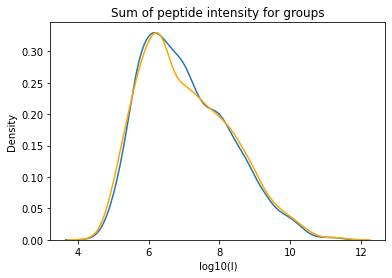

In [30]:
sns.kdeplot(x=[np.log10(x) for x in df['IntensitySum1']])
sns.kdeplot(x=[np.log10(x) for x in df['IntensitySum2']], color='orange')
plt.title('Sum of peptide intensity for groups')
plt.xlabel('log10(I)')

/tmp/ipykernel_3108/3753872381.py:3: RuntimeWarning: divide by zero encountered in log
  log_sum_I = [np.log(x) for x in df.groupby('Protein').sum()['IntensitySum'].values]


Text(0, 0.5, 'log10(MEAN(FC))')

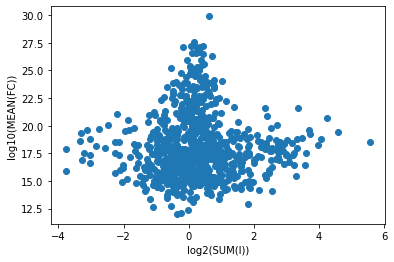

In [30]:
plt.clf()
mean_FC = [np.log2(x) for x in df.groupby('Protein').mean()['FC'].values]
log_sum_I = [np.log(x) for x in df.groupby('Protein').sum()['IntensitySum'].values]
plt.scatter(x=mean_FC,y=log_sum_I)
plt.xlabel('log2(SUM(I))')
plt.ylabel('log10(MEAN(FC))')


### Differential expression
Peptide Level:

In [32]:
df['pvalue'] = df.apply(lambda x: get_p_value(x, GroupOneCols, GroupTwoCols), axis=1)
df

/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=

,PeptideSequence,Charge,Decoy,Protein,RetentionTime,PeptideQValue,ProteinQValue,TM_M2012_010,TM_M2012_011,TM_M2012_012,...,PeptideCount1,PeptideCount2,IntensitySum1,IntensitySum2,IntensityMean1,IntensityMean2,FC,IntensitySum,labels,pvalue
1885,NPSSAGSWNSGSSGPGSTGNR,2,0,P02671,1770.050,0.000000,0.00000,76500800.0,6.027590e+08,210512000.0,...,30,42,3.217329e+09,4.137797e+09,1.072443e+08,9.851898e+07,1.088565,7.355126e+09,P02671,0.688968
2635,LTVLSQPK,2,0,P80748,2051.000,0.000000,0.00000,108445000.0,2.019230e+07,15145300.0,...,30,42,1.608453e+09,2.136061e+09,5.361511e+07,5.085860e+07,1.054199,3.744515e+09,P80748,0.841966
2639,AASGTTGTYQEWK,2,0,P04114,2051.590,0.000000,0.00000,4251980.0,6.607550e+06,10676400.0,...,30,42,1.556694e+08,2.931686e+08,5.188980e+06,6.980204e+06,0.743385,4.488380e+08,P04114,0.074556
12404,EVVTSEDGSDC(UniMod:4)PEAMDLGTLSGIGTLDGFR,3,0,P02671,5310.340,0.000000,0.00000,239767000.0,1.901960e+09,652418000.0,...,30,42,8.056381e+09,8.344606e+09,2.685460e+08,1.986811e+08,1.351644,1.640099e+10,P02671,0.307958
2531,QTAC(UniMod:4)KPEIAYAYK,3,0,P01031,2006.840,0.000000,0.00000,4731040.0,6.521440e+06,5357530.0,...,30,42,1.073765e+08,1.351631e+08,3.579218e+06,3.218169e+06,1.112191,2.425396e+08,P01031,0.454226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4646,NVHGINFVSPVR,2,0,P53634,2709.160,0.000000,0.00000,NaN,NaN,NaN,...,0,0,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.000000e+00,Other,NaN
11199,LTFFNSTLNTSGLVPEGDALPIPGAHRPGVVTK,5,0,O75891,4666.005,0.009295,0.00000,NaN,NaN,NaN,...,0,0,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.000000e+00,Other,NaN
1713,QLEEEQQALQK,2,0,P07951,1692.150,0.000438,0.00222,NaN,NaN,NaN,...,0,0,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.000000e+00,Other,NaN
4361,LFYSTFATDDRK,2,0,P30084,2623.420,0.001093,0.00000,NaN,NaN,NaN,...,0,0,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.000000e+00,Other,NaN


Text(0.5, 0, 'log2(Group 1 / Group 2)')

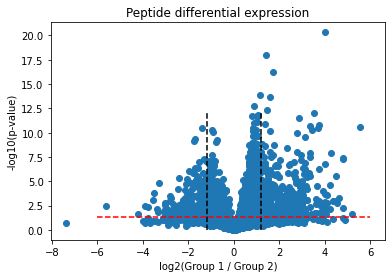

In [34]:
plt.scatter(x=[np.log2(x) for x in df['FC']] , y=[-np.log(val) for val in df['pvalue'].values])
plt.vlines(1.2, ymin=0, ymax=12, color='k', linestyle='dashed')
plt.vlines(-1.2, ymin=0, ymax=12,color='k', linestyle='dashed')
plt.hlines(1.31, xmin=-6, xmax=6, color='red', linestyle='dashed')
plt.title('Peptide differential expression')
plt.ylabel('-log10(p-value)')
plt.xlabel('log2(Group 1 / Group 2)')

Text(0.5, 0, 'log10(I)')

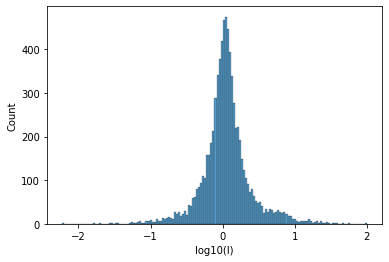

In [44]:
sns.histplot(x=[np.log10(x) for x in df['FC']])
plt.xlabel('log10(I)')

### Protein level

/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_527/3924577808.py:9: RuntimeWarning: Mean of empty slice
  logfold_change = np.log2(np.nanmean(vals_group_1)) - np.log2(np.nanmean(vals_group_2))
/tmp/ipykernel_527/3924577808.py:9: RuntimeWarning: Mean of empty slice
  logfold_change = np.log2(np.nanmean(vals_group_1)) - np.log2(np.nanmean(vals_group_2))
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/n

Number of significantly differing proteins: 147


/tmp/ipykernel_527/3924577808.py:9: RuntimeWarning: Mean of empty slice
  logfold_change = np.log2(np.nanmean(vals_group_1)) - np.log2(np.nanmean(vals_group_2))
/tmp/ipykernel_527/3924577808.py:9: RuntimeWarning: Mean of empty slice
  logfold_change = np.log2(np.nanmean(vals_group_1)) - np.log2(np.nanmean(vals_group_2))
/tmp/ipykernel_527/3924577808.py:9: RuntimeWarning: Mean of empty slice
  logfold_change = np.log2(np.nanmean(vals_group_1)) - np.log2(np.nanmean(vals_group_2))
/tmp/ipykernel_527/3924577808.py:9: RuntimeWarning: Mean of empty slice
  logfold_change = np.log2(np.nanmean(vals_group_1)) - np.log2(np.nanmean(vals_group_2))
/tmp/ipykernel_527/3924577808.py:9: RuntimeWarning: Mean of empty slice
  logfold_change = np.log2(np.nanmean(vals_group_1)) - np.log2(np.nanmean(vals_group_2))
/tmp/ipykernel_527/3924577808.py:9: RuntimeWarning: Mean of empty slice
  logfold_change = np.log2(np.nanmean(vals_group_1)) - np.log2(np.nanmean(vals_group_2))
/tmp/ipykernel_527/3924577808.py:9

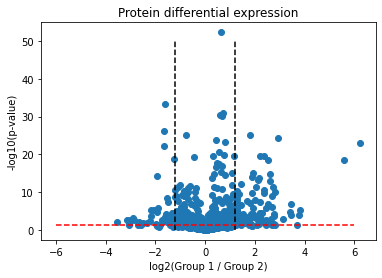

In [37]:

pvalues = []
proteins = []
logfold_changes = []
for protein in df['Protein'].unique():
    protein_df = df[df['Protein'] == protein]
    vals_group_1 = protein_df[GroupOneCols].values.flatten()
    vals_group_2 = protein_df[GroupTwoCols].values.flatten()
    statistic, pval = stats.ttest_ind(vals_group_1[~np.isnan(vals_group_1)], vals_group_2[~np.isnan(vals_group_2)])
    logfold_change = np.log2(np.nanmean(vals_group_1)) - np.log2(np.nanmean(vals_group_2))
    
    pvalues.append(pval)
    proteins.append(protein)
    logfold_changes.append(logfold_change)



log_pval = [-np.log(x) for x in pvalues]
dep = pd.DataFrame({'protein':proteins, 'pval': log_pval, 'FC':logfold_changes})

plt.scatter(x=logfold_changes,y=log_pval)

plt.vlines(1.2, ymin=0, ymax=50, color='k', linestyle='dashed')
plt.vlines(-1.2, ymin=0, ymax=50,color='k', linestyle='dashed')
plt.hlines(1.31, xmin=-6, xmax=6, color='red', linestyle='dashed')
plt.title('Protein differential expression')
plt.ylabel('-log10(p-value)')
plt.xlabel('log2(Group 1 / Group 2)')

dep = dep[dep['pval'] >1.3]
dep = dep[(dep['FC'] < -1.2) | (dep['FC'] > 1.2)]
print(f"Number of significantly differing proteins: {len(dep.index)}")

<AxesSubplot:ylabel='Count'>

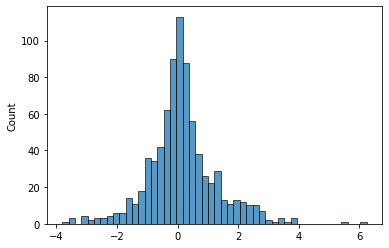

In [38]:
sns.histplot(logfold_changes)

## DPKS
---

In [3]:
from dpks.quant_matrix import QuantMatrix

quant_matrix = QuantMatrix(
    quantification_file=f"{MS_DATA_PATH}/220316_ghost_nrt_filtered.tsv",
    design_matrix_file=f"{MS_DATA_PATH}/design_matrix_group_de_early_time_points_subtypes.tsv"
)

quantified_proteins = (
    quant_matrix
    .filter() # filter for q-values (removes rows with low q value (peptides), Q = 0.01) and removes decoys
    .normalize(method="mean", use_rt_sliding_window_filter = True) # best type of normalization is RT-sliding window
    .quantify(method="maxlfq") # play around with minimum_subgroups (default is set 1)
)


/home/erikh/master-thesis/my-venv/lib/python3.9/site-packages/dpks/normalization.py:116: RuntimeWarning: Mean of empty slice
  sample_means = np.nanmean(X, axis=0)


In [6]:
save_protein_list(quantified_proteins.to_df()['Protein'].values,f"{MS_DATA_PATH}/proteins.csv")

In [51]:

compare_df = quantified_proteins.compare_groups(
    method='linregress',
    group_a=1,
    group_b=2,
    min_samples_per_group = 2, # play around with this 
    level='protein',
    
).to_df()
compare_df


,Protein,Group1Mean,Group2Mean,Log2FoldChange1-2,PValues1-2,Group1RepCounts,Group2RepCounts,CorrectedPValue,TM_M2012_010,TM_M2012_011,...,TM_M2012_177,TM_M2012_178,TM_M2012_182,TM_M2012_183,TM_M2012_186,TM_M2012_188,TM_M2012_189,TM_M2012_196,TM_M2012_197,TM_M2012_198
0,P06396,21.288717,21.226708,0.062010,0.694861,30,42,0.721447,21.690603,20.691873,...,20.419413,21.028937,21.542064,21.509333,21.198022,21.245511,21.200419,23.029393,23.389134,23.470304
1,P10643,21.516173,21.613422,-0.097249,0.503560,30,42,0.625305,21.677649,21.190349,...,21.893203,21.188014,21.371173,21.436145,21.356409,21.040272,21.362647,21.331875,21.524378,21.930228
2,P03952,20.936229,20.612498,0.323731,0.045767,30,42,0.149304,21.023477,20.770036,...,20.505599,20.608387,20.970957,20.752389,21.042518,20.957229,21.163873,22.332772,22.704704,22.773377
3,P02750,23.510573,23.954318,-0.443745,0.003362,30,42,0.023420,22.807610,23.269826,...,23.784981,24.566548,24.806581,24.787613,22.859750,22.901881,23.686287,24.103840,23.764547,24.052968
4,Q04756,19.586920,18.838137,0.748783,0.000072,30,41,0.001191,19.657972,19.115191,...,18.220235,18.721893,18.931209,18.973254,19.296811,18.608288,19.034313,20.708523,20.283616,20.454671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,P01275,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1035,P16104,NaN,NaN,NaN,NaN,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.966682
1036,O00194,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,Q6R327,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 0, 'log2(Group 1 / Group 2)')

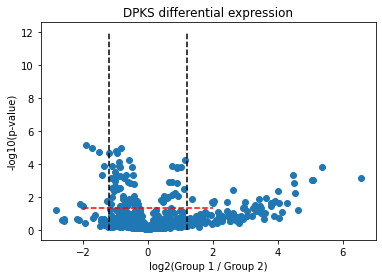

In [53]:
plt.scatter(x=compare_df['Log2FoldChange1-2'], y=-1.0 * np.log10(compare_df['CorrectedPValue']))
plt.vlines(1.2, ymin=0, ymax=12, color='black', linestyle='dashed')
plt.vlines(-1.2, ymin=0, ymax=12,color='black', linestyle='dashed')
plt.hlines(1.31, xmin=-2, xmax=2, color='red', linestyle='dashed')
plt.title('DPKS differential expression')
plt.ylabel('-log10(p-value)')
plt.xlabel('log2(Group 1 / Group 2)')

In [54]:
dep = compare_df
dep = dep[dep['CorrectedPValue'] > 0.1]
dep = dep[(dep['Log2FoldChange1-2'] < -1.2) | (dep['Log2FoldChange1-2'] > 1.2)]
dep

,Protein,Group1Mean,Group2Mean,Log2FoldChange1-2,PValues1-2,Group1RepCounts,Group2RepCounts,CorrectedPValue,TM_M2012_010,TM_M2012_011,...,TM_M2012_177,TM_M2012_178,TM_M2012_182,TM_M2012_183,TM_M2012_186,TM_M2012_188,TM_M2012_189,TM_M2012_196,TM_M2012_197,TM_M2012_198
35,P16930,21.802933,19.195807,2.607126,0.053861,4,9,0.169237,NaN,NaN,...,NaN,18.983453,18.482919,NaN,17.548541,NaN,NaN,20.440582,20.334344,19.925836
42,O75874,23.448107,20.906993,2.541114,0.135744,4,9,0.297938,NaN,NaN,...,NaN,19.883048,19.827454,20.557615,NaN,NaN,NaN,22.049731,24.008172,25.080020
44,Q9BWD1,20.641351,18.810445,1.830906,0.112361,3,3,0.269395,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.319443,18.886345,20.225547
59,Q03154,22.640316,20.031275,2.609041,0.024612,5,14,0.100639,NaN,NaN,...,NaN,20.376503,20.323743,20.641462,NaN,NaN,NaN,21.065284,22.446629,23.901193
67,P02452,23.109975,21.828200,1.281774,0.080948,19,35,0.215742,NaN,22.679662,...,15.794946,NaN,17.628596,17.364566,23.798755,23.959525,24.908712,18.562030,21.737459,24.343188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,Q9UBR1,21.798614,20.031316,1.767299,0.187657,3,2,0.364923,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.370013,20.692619
962,P52895,19.572192,16.768777,2.803415,0.197066,2,2,0.377077,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.192512,NaN,17.345042
967,P11217,21.643120,18.423842,3.219278,0.040870,3,4,0.139424,NaN,NaN,...,NaN,NaN,15.942518,NaN,NaN,NaN,NaN,18.072732,19.286693,20.393425
1022,P01769,18.205530,19.612539,-1.407009,0.146783,2,2,0.314085,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.164946,NaN,NaN


<AxesSubplot:ylabel='Count'>

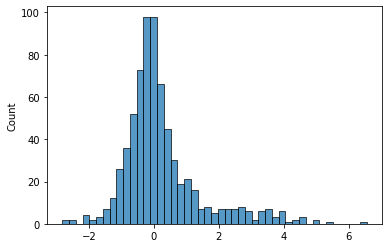

In [56]:
sns.histplot(compare_df['Log2FoldChange1-2'].values)